In [1]:
#pip install arch

In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
import seaborn as sns
from arch import arch_model
import datetime

In [3]:
# Directories
OUTPUT_DIR = '../Outputs/equity/'
CLUSTER_DIR = '../Outputs/country_clusters/'

# Filter by year
start_date = '2015-09-27'
end_date = '2021-01-31'

In [4]:
# Load equity ETF log returns
equity_rets_w = pd.read_pickle(OUTPUT_DIR + 'equity_etf_returns_weekly.pkl')

# Load market returns, i.e., EM Aggregate returns from EEM ETF index
market_rets_w = pd.read_pickle(OUTPUT_DIR + 'equity_EM_agg_market_returns.pkl')

# Load clusters
equity_clusters = pd.read_pickle(CLUSTER_DIR + 'clusters_equity_etf_full.pkl')

In [15]:
# Plot 
def plot_perf(perf, label, title):
    fig, ax = plt.subplots(nrows=1, figsize=(12,6))
    if type(perf) is not list:
        perf = [perf]
        label = [label]
    for i in range(len(perf)):
        ax.plot(perf[i], linewidth=1, label=label[i])
    #ax.plot(perf_bm, linewidth=1, linestyle='--', c='black', label='Market')
    ax.set_ylabel('Percent (%)')
    ax.set_title(title)
    ax.legend()

# Purpose of Notebook
1. Calculate dispersion between country and EM aggregate market: this will serve as the "distance" measure between country returns and the aggregate EM market return

# 1. Dispersion as Cross-Sectional Correlation
Assume country returns and the EM agg market are related by:
$$
R_{i,t} = \beta_i R_{w,t} + e_{i,t}
$$
where $e_{i,t}$ ~ N[0, $\sigma_e(t)$]. <br>
Then the cross-sectional correlation is:
$$
\rho_{i,w} = \frac{1}{\sqrt{1 + \sigma_e^2 / \beta_i^2 \sigma_w^2}}
$$

## Estimate market volatility

In [6]:
# Model time variation in world market volatility using GARCH(1,1)
def calc_garch_forecast(ret_series, column, K = 52, time = 52):
    date_list = []
    vol_list = []

    for i in range(ret_series.shape[0] - K):
        train_ret = ret_series.iloc[:i+K, :]
        am = arch_model(train_ret[column] * 100, mean='ARX', lags=0, vol='GARCH', p=1, o=0, q=1, dist='Normal')
        am_est = am.fit(disp='off')
        vol_forecast = np.sqrt(am.forecast(params=am_est.params, horizon=1).variance.iat[-1,0]) / 100 * np.sqrt(time)

        date_list.append(ret_series.index[i+K])
        vol_list.append(vol_forecast)

    vol_garch = pd.Series(vol_list, index=date_list, name='GARCH Vol')
    
    return vol_garch

In [7]:
market_vol = calc_garch_forecast(market_rets_w, 'EEM ETF')

## Estimate beta's
Assume time varying betas for each country, against the EM agg market returns.

In [8]:
# Run regression to determine betas 
def calc_beta_ret(df, market_port_ret, window=52):
    # Find country beta's through rolling regression
    y = market_port_ret
    rolling_betas = {}
    for c in df.columns:
        X = df[c]
        model = RollingOLS(y, X, window)
        rolling_res = model.fit()
        rolling_betas[c] = rolling_res.params.dropna()
    
    # Put all beta's for every country and every date in a dataframe
    out_df = pd.DataFrame()
    for key, value in rolling_betas.items():
        col = pd.DataFrame(value[key])
        if out_df.empty:
            out_df = out_df.append(col)
        else:
            out_df = pd.concat([out_df, col], axis=1)
    
    return out_df

In [9]:
betas_df = calc_beta_ret(equity_rets_w, market_rets_w['EEM ETF'])

In [10]:
# Find residuals
residuals = {}
for c in betas_df:
    residuals[c] = equity_rets_w[c] - betas_df[c] * market_rets_w['EEM ETF']
resid_df = pd.DataFrame(residuals).dropna()

In [11]:
# Find variance of residuals
vol_resid = {}
for c in resid_df:
    vol_resid[c] = calc_garch_forecast(resid_df, c)
vol_resid_df = pd.DataFrame(vol_resid).dropna()

## Calculate dispersion

In [12]:
def calc_dispersion(vol_market, vol_country, beta_country):
    rho = 1/np.sqrt(1 + vol_country**2/(beta_country**2 * vol_market**2))
    return rho

In [13]:
rho_ = {}
for c in vol_resid_df:
    beta_country = betas_df[c]
    vol_country = vol_resid_df[c]
    rho_[c] = calc_dispersion(market_vol, vol_country, beta_country)
rho_df = pd.DataFrame(rho_).dropna()

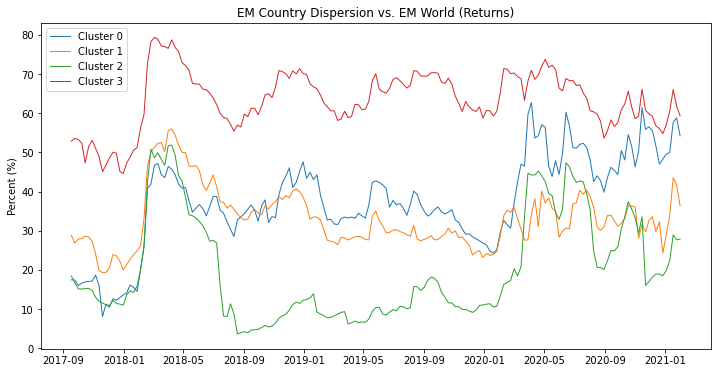

In [22]:
# Plot dispersion by cluster
rho_mean = {}
for cluster_num in list(equity_clusters['cluster_label'].unique()):
    countries_selected = list(equity_clusters[equity_clusters['cluster_label']==cluster_num]['Countries'])
    rho_cluster = rho_df[countries_selected]
    rho_mean['Cluster ' + str(cluster_num)] = rho_cluster.mean(axis=1)

rho_mean_df = pd.DataFrame(rho_mean)
plot_perf(perf=[rho_mean_df[x]*100 for x in list(rho_mean_df.columns.values)], \
        label=list(rho_mean_df.columns.values), title=f'EM Country Dispersion vs. EM World (Returns)')